<a href="https://colab.research.google.com/github/ChoiSenn/Study/blob/main/AI/PyTorch/deep_learning_with_python_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.4 classifying movie reviews

<br>

In [19]:
import keras
keras.__version__  # 버전 체크

'2.9.0'

## IMDB 데이터셋

IMDB
- 인터넷 영화 데이터베이스로부터 가져온 (호불호)양극단의 리뷰 50,000개로 이루어진 데이터셋.
- 훈련 데이터 25,000개와 테스트 데이터 25,000개로 구성.
- 각각 50%는 부정, 50%는 긍정적인 리뷰로 구성.
- 케라스에 포함.
- 전처리 되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있음.

<br>

훈련 데이터와 테스트 데이터를 나누는 이유 : 같은 데이터에서 모델을 훈련하고 테스트를 동시에 하는 것이 아니라, 새로운 데이터에 대해 모델의 성능을 검증하기 위해.

<br>

먼저 IMDB 데이터셋을 로드.

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

train_data[0]  # train data의 리뷰 출력
train_labels[0]  # train data의 긍정/부정 출력
max([max(sequence) for sequence in train_data])  # 단어 인덱스가 가장 많은 쪽 출력

9999

매개변수로 준 num_words=10000은 훈련 데이터에서 가장 자주 나타나는 단어 10,000개만 사용하겠다는 의미. 그리고 드물게 나타나는 단어를 무시하여 적절한 크기의 벡터 데이터 얻음.

*train_data[0]으로 0번째 리뷰 출력(숫자 시퀀스 형태), train_labels[0]으로 0번째 리뷰의 부정/긍정을 출력(부정은 0, 긍정은 1)*

*자주 등장하는 단어 10,000개로 제한했기에 인덱스는 10,000을 넘지 않음.*

<br>

train_data와 word_index(단어와 정수를 매핑한 딕셔너리)를 이용해 리뷰 데이터를 원래 영어 단어로 변환해볼 수 있음.

In [ ]:
word_index = imdb.get_word_index()  # 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # 정수 인덱스와 단어를 매핑하도록 뒤집음

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])  # 디코딩. 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺌.

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

*숫자 시퀀스 변환 전의 원래 리뷰가 출력된 모습*

<br>

## 데이터 준비

숫자 리스트로 바로 주입할 수 없으므로 다음과 같은 두 가지 방식으로 리스트를 텐서로 변환.
- 같은 길이가 되도록 리스트에 padding을 추가하고 (samples, sequesnce_length) 크기의 정수 텐서로 변환. 정수 텐서를 다룰 수 있는 층을 신경망의 첫 층으로 사용.(Embedding 층)
- 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환. 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망 첫 번째 층으로 사용.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듦
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듦
    return results

x_train = vectorize_sequences(train_data)  # 훈련 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data) 

y_train = np.asarray(train_labels).astype('float32')  # 레이블을 벡터로 변환
y_test = np.asarray(test_labels).astype('float32')

x_train[0]  # 확인

array([0., 1., 1., ..., 0., 0., 0.])

*원-핫 인코딩을 이용하여 벡터로 변환한 모습*

<br>

## 신경망 모델 만들기

입력 데이터가 벡터이고 레이블은 스칼라(1 or 0)인 경우에 잘 작동하는 네트워크는 relu 활성화 함수를 사용한 완전연결층을 그냥 쌓은 네트워크.

Dense 층에 전달할 매개변수는 은닉 유닛의 개수. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 됨.

16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻. 입력 데이터와 W를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영. 해당 차원을 '신경망이 내제된 표현을 학습할 때 가질 수 있는 자유도'로 이해 가능.

은닉 유닛을 늘려 더 고차원으로 만들면 신경망이 더 복잡한 표현을 학습할 수 있지만, 계산 비용이 커지고 원치 않은 패턴을 학습할 수 있음.

우선은 16개의 은닉 유닛을 가진 두 개의 은닉층과 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층을 두기로 함.

중간의 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률을 출력하기 위해 시그모이드 활성화 함수를 사용. relu는 음수를 0으로 만드는 함수. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석 가능.

<br>

신경망을 케라스로 구현.

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

손실 함수와 옵티마이저를 선택.

이진 분류 문제이고 신경망의 출력이 확률이기 때문에 binary_crossentropy 손실이 적합. (확률을 출력하는 모델을 사용 시에는 크로스엔트로피가 최선의 선택)

다음으로 rmsprop 옵티마이저와 binary_crossentropy 손실 함수로 모델을 설정. 훈련하는 동안 accuracy로 모니터링.

In [12]:
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


<br>

## 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 일정 샘플을 떼어내서 검증 세트를 만들어야 함.

In [13]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개씩 미니 배치를 만들어 20번 epochs 동안 훈련시킴. 동시에 따로 떼어놓은 10,000개의 샘플에 있어서 loss와 accuracy를 측정.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

Epoch 1/20
30/30 [==============================] - 4s 46ms/step - loss: 0.5267 - accuracy: 0.7792 - val_loss: 0.3957 - val_accuracy: 0.8705
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.3158 - accuracy: 0.9017 - val_loss: 0.3248 - val_accuracy: 0.8726
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2274 - accuracy: 0.9278 - val_loss: 0.2921 - val_accuracy: 0.8841
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1810 - accuracy: 0.9411 - val_loss: 0.2907 - val_accuracy: 0.8811
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1467 - accuracy: 0.9549 - val_loss: 0.2792 - val_accuracy: 0.8878
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1195 - accuracy: 0.9635 - val_loss: 0.2891 - val_accuracy: 0.8875
Epoch 7/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0957 - accuracy: 0.9733 - val_loss: 0.3186 - val_accuracy: 0.8833
Epoch 8/20
30

*한 에폭이 끝날 때마다 loss와 accuracy를 계산하여 출력된 모습.*

<br>

model.fit() 메소드는 History 객체를 반환. 이는 훈련하는 동안 발생한 모든 정보를 담은 딕셔너리인 history 속성을 갖고 있음.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

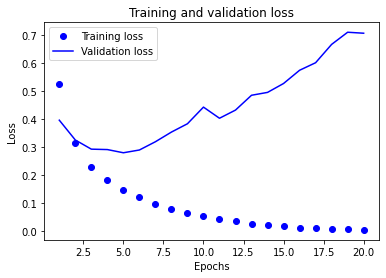

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

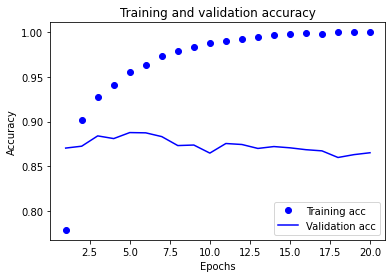

In [ ]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

*네 가지 측정 지표를 이용해 훈련과 검증 데이터에 대한 손실과 정확도를 그려본 모습. 점선은 훈련 손실과 정확도이며, 실선은 검증 손실과 정확도.*

<br>

볼 수 있듯, 훈련 손실이 에폭마다 감소하고 훈련 정확도는 에폭마다 증가. 경사 하강법에 따라 반복마다 최소화됨. 그러나 검증 손실과 정확도는 감소/증가하다가 어느 순간에서 역전되는 모습을 확인 가능. 어느 순간에 과적합되어 훈련 세트 이외의 데이터에는 일반화 되지 못한다는 것을 알 수 있음.

이런 경우, 과대적합 방지를 위해 특정 에폭 이후에 훈련을 중지할 수 있음.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.4712 - accuracy: 0.8139
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2707 - accuracy: 0.9054
Epoch 3/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2048 - accuracy: 0.9278
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.3079 - accuracy: 0.8786


[0.3079497218132019, 0.878600001335144]

*87%의 정확도를 달성한 모습*

<br>

## 훈련된 모델로 새로운 데이터에 대해 예측하기

predict 메서드를 사용해서 리뷰가 긍정적일 확률 예측 가능.

In [ ]:
model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


array([[0.26858276],
       [0.99954   ],
       [0.93990934],
       ...,
       [0.16798516],
       [0.11966275],
       [0.7567183 ]], dtype=float32)

*모델이 어떤 샘플에 대해서는 0.9, 0.1 정도로 확신을 가지고 있지만, 어떤 샘플에 대해서는 0.7 정도로 애매한 결과를 보임*

<br>

## 추가 실험

1. (한 개 또는) 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인.

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))  # 은닉층 하나 추가
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 3s 82ms/step - loss: 0.5012 - accuracy: 0.7754 - val_loss: 0.4000 - val_accuracy: 0.8394
Epoch 2/20
30/30 [==============================] - 2s 71ms/step - loss: 0.2902 - accuracy: 0.9035 - val_loss: 0.2946 - val_accuracy: 0.8893
Epoch 3/20
30/30 [==============================] - 2s 70ms/step - loss: 0.2121 - accuracy: 0.9288 - val_loss: 0.2781 - val_accuracy: 0.8905
Epoch 4/20
30/30 [==============================] - 2s 79ms/step - loss: 0.1711 - accuracy: 0.9417 - val_loss: 0.2850 - val_accuracy: 0.8874
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1387 - accuracy: 0.9554 - val_loss: 0.2834 - val_accuracy: 0.8887
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1117 - accuracy: 0.9649 - val_loss: 0.3113 - val_accuracy: 0.8832
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0959 - accuracy: 0.9706 - val_loss: 0.3177 - val_accuracy: 0.8845
Epoch 8/20
30

[0.3522029221057892, 0.8654000163078308]

*86%의 정확도로, 두 개의 은닉층을 사용하였을 때보다는 약간 정확도가 하락한 모습.*

<br>

2. 층의 은닉 유닛을 추가하거나 줄이기 (32개)

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 40ms/step - loss: 0.0984 - accuracy: 0.9719 - val_loss: 0.2156 - val_accuracy: 0.9174
Epoch 2/20
30/30 [==============================] - 1s 38ms/step - loss: 0.0776 - accuracy: 0.9797 - val_loss: 0.2107 - val_accuracy: 0.9229
Epoch 3/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0623 - accuracy: 0.9867 - val_loss: 0.2440 - val_accuracy: 0.9144
Epoch 4/20
30/30 [==============================] - 1s 49ms/step - loss: 0.0509 - accuracy: 0.9891 - val_loss: 0.2492 - val_accuracy: 0.9136
Epoch 5/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0414 - accuracy: 0.9936 - val_loss: 0.2726 - val_accuracy: 0.9100
Epoch 6/20
30/30 [==============================] - 1s 35ms/step - loss: 0.0341 - accuracy: 0.9946 - val_loss: 0.3110 - val_accuracy: 0.9050
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0274 - accuracy: 0.9971 - val_loss: 0.3551 - val_accuracy: 0.8967
Epoch 8/20
30

[0.31267374753952026, 0.8798800110816956]

*88% 정도의 비슷한 정확도를 보임.*

<br>

3. binary_crossentropy 대신에 mse 손실 함수 사용

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 53ms/step - loss: 0.1461 - accuracy: 0.9481 - val_loss: 0.1390 - val_accuracy: 0.9511
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1075 - accuracy: 0.9642 - val_loss: 0.1540 - val_accuracy: 0.9447
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.0894 - accuracy: 0.9707 - val_loss: 0.1691 - val_accuracy: 0.9375
Epoch 4/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0691 - accuracy: 0.9798 - val_loss: 0.1882 - val_accuracy: 0.9326
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0581 - accuracy: 0.9843 - val_loss: 0.2104 - val_accuracy: 0.9262
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0440 - accuracy: 0.9877 - val_loss: 0.2353 - val_accuracy: 0.9212
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0333 - accuracy: 0.9915 - val_loss: 0.2837 - val_accuracy: 0.9101
Epoch 8/20
30

[0.08792755007743835, 0.8815600275993347]

*역시나 88% 정도의 정확도*

4. relu 대신 tanh 활성화 함수 사용

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 49ms/step - loss: 0.5290 - accuracy: 0.7761 - val_loss: 0.4048 - val_accuracy: 0.8529
Epoch 2/20
30/30 [==============================] - 1s 39ms/step - loss: 0.3113 - accuracy: 0.9005 - val_loss: 0.3050 - val_accuracy: 0.8894
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2253 - accuracy: 0.9264 - val_loss: 0.2797 - val_accuracy: 0.8885
Epoch 4/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1785 - accuracy: 0.9408 - val_loss: 0.2838 - val_accuracy: 0.8863
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1437 - accuracy: 0.9550 - val_loss: 0.2865 - val_accuracy: 0.8851
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1178 - accuracy: 0.9645 - val_loss: 0.3112 - val_accuracy: 0.8804
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0955 - accuracy: 0.9720 - val_loss: 0.3211 - val_accuracy: 0.8825
Epoch 8/20
30

[0.3205924332141876, 0.8799600005149841]

*88% 정도의 정확도*

#6.2 Understanding recurrent neural networks

## 케라스의 순환 층


SimpleRNN
- 케라스에서 제공하는 기초적인 RNN 구조.
- 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리. 즉, (timesteps, input_features) 크기가 아니라 (batch_size, timesteps, input_features) 크기의 입력을 받음.
- 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나, 입력 시퀀스에 대한 마지막 출력만 반환할 수 있음. (return_sequences 매개변수로 선택)

In [ ]:
import keras
keras.__version__

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


*네트워크의 표현력 증가를 위해 여러 개의 순환 층을 차례대로 쌓을 때에는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정.*

<br>

IMDB 영화 리뷰 분류 문제에 SimpleRNN을 적용.

In [ ]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences  # 버전? 오류로 수정

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)  # 버전? 오류로 수정
input_test = pad_sequences(input_test, maxlen=maxlen)  # 버전? 오류로 수정
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


Embedding 층과 SimpleRNN 층을 사용해 간단한 순환 네트워크를 훈련.

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 33s 194ms/step - loss: 0.6167 - acc: 0.6465 - val_loss: 0.5242 - val_acc: 0.7394
Epoch 2/10
157/157 [==============================] - 24s 154ms/step - loss: 0.3989 - acc: 0.8315 - val_loss: 0.5039 - val_acc: 0.7566
Epoch 3/10
157/157 [==============================] - 24s 153ms/step - loss: 0.3098 - acc: 0.8767 - val_loss: 0.4325 - val_acc: 0.8082
Epoch 4/10
157/157 [==============================] - 26s 164ms/step - loss: 0.2406 - acc: 0.9090 - val_loss: 0.5404 - val_acc: 0.8044
Epoch 5/10
157/157 [==============================] - 24s 155ms/step - loss: 0.2027 - acc: 0.9271 - val_loss: 0.3964 - val_acc: 0.8520
Epoch 6/10
157/157 [==============================] - 24s 154ms/step - loss: 0.1270 - acc: 0.9561 - val_loss: 0.4524 - val_acc: 0.8332
Epoch 7/10
157/157 [==============================] - 25s 161ms/step - loss: 0.0879 - acc: 0.9722 - val_loss: 0.5603 - val_acc: 0.7978
Epoch 8/10
157/157 [==============================] - 2

학습 완료. 이제 훈련과 검증의 손실과 정확도를 그래프로 그려봄. (대략 73~85%의 정확도)

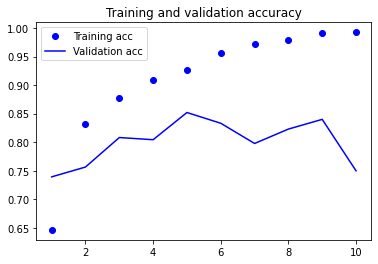

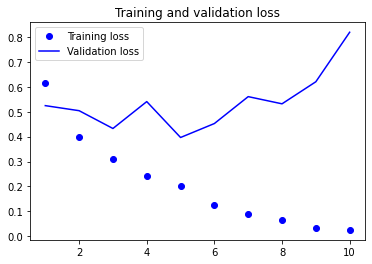

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

지금 이 순환 네트워크는 3.4의 신경망 모델보다 성능이 높지는 않음. 왜냐하면 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문.(얻은 정보가 적음) 그리고 다른 이유는 SimpleRNN이 텍스트와 같이 긴 시퀀스를 처리하는 데에는 적합하지 않기 때문.

<br>

## 케라스를 사용한 LSTM 예제

이번에는 LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련.

이 네트워크는 SimpleRNN 모델과 비슷. LSTM 층은 출력 차원만 지정하고 다른 매개변수들은 케라스의 기본값으로 남겨둠.

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 69s 422ms/step - loss: 0.5232 - acc: 0.7556 - val_loss: 0.3714 - val_acc: 0.8570
Epoch 2/10
157/157 [==============================] - 56s 355ms/step - loss: 0.3000 - acc: 0.8838 - val_loss: 0.3497 - val_acc: 0.8472
Epoch 3/10
157/157 [==============================] - 57s 364ms/step - loss: 0.2341 - acc: 0.9112 - val_loss: 0.3023 - val_acc: 0.8690
Epoch 4/10
157/157 [==============================] - 56s 358ms/step - loss: 0.2029 - acc: 0.9255 - val_loss: 0.4730 - val_acc: 0.8414
Epoch 5/10
157/157 [==============================] - 56s 355ms/step - loss: 0.1791 - acc: 0.9351 - val_loss: 0.3379 - val_acc: 0.8614
Epoch 6/10
157/157 [==============================] - 57s 364ms/step - loss: 0.1599 - acc: 0.9442 - val_loss: 0.3053 - val_acc: 0.8840
Epoch 7/10
157/157 [==============================] - 56s 357ms/step - loss: 0.1469 - acc: 0.9474 - val_loss: 0.3130 - val_acc: 0.8686
Epoch 8/10
157/157 [==============================] - 5

*84~88% 정도의 정확도*

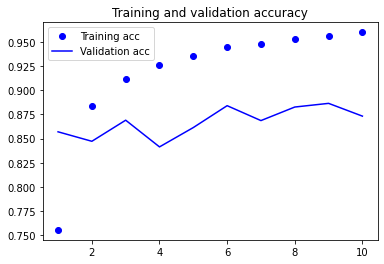

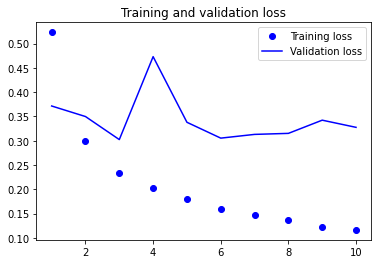

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#6.3 순환 신경망의 고급 사용법

순환 신경망의 성능과 일반화 능력을 향상시키기 위한 세 가지 고급 기술
- 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용.
- 순환 층 스태킹 : 네트워크의 표현 능력을 증가 (대신 계산 비용이 많이 듦)
- 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지.

<br>

## 기온 예측 문제

이번에는 위에서 다뤄왔던 텍스트 데이터가 아닌 날씨 시계열 데이터셋을 사용.

해당 데이터 셋에는 수년간 걸쳐 기온, 기압, 습도, 풍향 등과 같은 14개의 관측치가 10분마다 기록되어 있음. 이 중 2009~2016년 사이의 데이터 사용.

최근 데이터를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측.

In [5]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


*420,551개 데이터 전체를 넘파이 배열로 바꿈.*

In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

*시간에 따른 기온 그래프 시각화.*

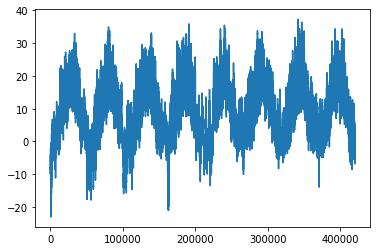

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

*온도에 주기성이 있음을 확실히 알 수 있음.*

다음은 기간을 좁혀 첫 10일간의 온도 데이터를 그래프로 시각화. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있음.

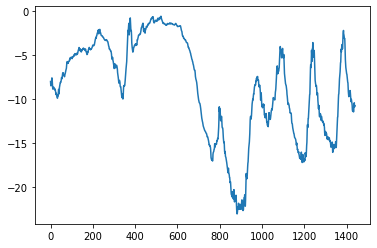

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

*이 데이터는 아주 추운 겨울 중 10일. 일별 주기성을 볼 수 있음.*

<br>

## Preparing the data

지난 몇 달간의 데이터를 사용해 다음 날의 온도를 예측. (이는 다음 달의 평균 온도 예측보다 어려움)

lookback 타임스텝(10분) 만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측.

사용할 변수
- lookback = 1440 : 10일 전 데이터로 돌아감.
- steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링.
- delay = 144 : 24시간이 지난 데이터가 타깃이 됨.

시작 전 작업
- 신경망에 주입할 수 있는 형태로 데이터 전처리. 이미 수치형이므로 추가적인 벡터화는 필요하지 않으나, 각 시계열 특성의 범위가 서로 다름. 따라서 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꿈.
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듦. 이 데이터셋의 샘플은 중복이 많음. 따라서 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신 원본 데이터를 사용해 그때 그때 배치를 만듦.

<br>

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리.

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

제너레이터 함수의 매개변수
- data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용.
- shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정.
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정.

In [3]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

이제 generator 함수를 사용해 훈련/검증/테스트용으로 세 개의 제너레이터를 만듦.

훈련은 처음 200,000개 타임스텝을 사용하고 검증은 그 다음 100,000개, 테스트는 나머지를 사용.

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 기본적인 머신러닝 방법

데이터를 펼쳐서 두 개의 Dense 층을 통과시키는 완전 연결 네트워크를 보여줌. 전형적인 회귀 문제이므로 마지막 Dense 층에는 활성화 함수를 두지 않음. 손실함수는 MAE.



In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 12s 19ms/step - loss: 1.0383 - val_loss: 0.4578
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3876 - val_loss: 0.3447
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2968 - val_loss: 0.3103
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2704 - val_loss: 0.3161
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2556 - val_loss: 0.3473
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2472 - val_loss: 0.3063
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2382 - val_loss: 0.3227
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2315 - val_loss: 0.3159
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2293 - val_loss: 0.3136
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2223 - val_loss: 0.3235

*34% 정도의 손실.*

훈련 손실과 검증 손실의 그래프를 그려봄.

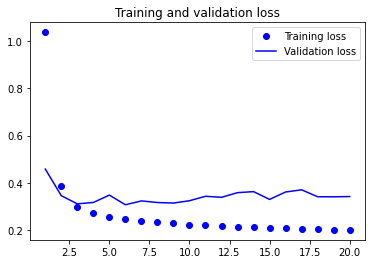

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 첫 번째 순환 신경망

첫 번째 완전 연결 네트워크는 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버려 잘 작동하지 않았음. 대신 인과관계와 순서가 의미있는 시퀀스 데이터 그대로 사용.

순환 시퀀스 처리 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용.

그 중 GRU 층을 사용. GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 계산 비용이 덜 듦.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 20s 32ms/step - loss: 0.3019 - val_loss: 0.2725
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2817 - val_loss: 0.2734
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2772 - val_loss: 0.2699
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2715 - val_loss: 0.2633
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2675 - val_loss: 0.2627
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2647 - val_loss: 0.2663
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2584 - val_loss: 0.2637
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2527 - val_loss: 0.2735
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2484 - val_loss: 0.2733
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2446 - val_los

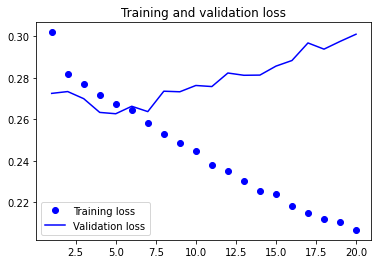

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*이전의 모델보다 훨씬 좋은 결과.*

<br>

## 과대적합을 감소하기 위해 순환 드롭아웃 사용

몇 번의 에폭 뒤에 훈련 손실과 검증 손실이 현저히 벌어지게 되면 과대적합임을 알 수 있음. 이를 해결하기 위해 드롭아웃 기법을 사용.

드롭아웃 : 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법.

기존에는 순환층 이전에 드롭아웃을 적용하면 학습에 방해가 되는 것으로 알려져왔으나, 야린 갈이 순환 네트워크에서 적절하게 드롭아웃을 사용하는 방법을 알아냄. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크를 모든 타임스텝에 적용.

케라스의 모든 순환층은 dropout과 recurrent_dropout, 두 개의 드롭아웃 매개변수를 가짐. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 확인.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 385s 767ms/step - loss: 0.3362 - val_loss: 0.2779
Epoch 2/40
500/500 [==============================] - 380s 760ms/step - loss: 0.3052 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 381s 763ms/step - loss: 0.3008 - val_loss: 0.2715
Epoch 4/40
500/500 [==============================] - 380s 761ms/step - loss: 0.2955 - val_loss: 0.2720
Epoch 5/40
500/500 [==============================] - 378s 756ms/step - loss: 0.2917 - val_loss: 0.2704
Epoch 6/40
500/500 [==============================] - 377s 755ms/step - loss: 0.2887 - val_loss: 0.2707
Epoch 7/40
500/500 [==============================] - 377s 755ms/step - loss: 0.2856 - val_loss: 0.2691
Epoch 8/40
500/500 [==============================] - 379s 757ms/step - loss: 0.2811 - val_loss: 0.2754
Epoch 9/40
500/500 [==============================] - 378s 757ms/step - loss: 0.2778 - val_loss: 0.2780
Epoch 10/40
500/500 [==============================] - 377s 755ms/step - lo

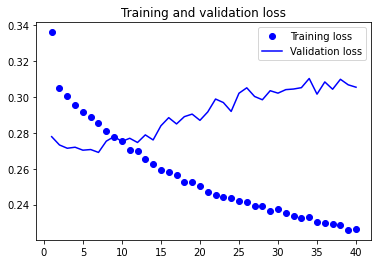

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*과대적합이 일어나지 않은 모습*

<br>

## 스태킹 순환 층

과대적합은 더 이상 없지만 병목현상이 있으므로 네트워크의 용량을 늘려야 함.

일반적으로 층의 유닛 수를 늘리거나 층을 추가. 순환층 스태킹은 더 강력한 순환 네트워크를 만들 수 있음.

케라스에서 순환 층을 순서대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 함.

In [ ]:
# 시간 문제로 실행 보류

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


116/500 [=====>........................] - ETA: 9:40 - loss: 0.3551

KeyboardInterrupt: ignored

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


<br>

## 양방향 RNN 사용하기

양방향 RNN은 RNN의 변종이며, 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냄.

RNN은 순서 또는 시간에 민감. 즉, 입력 시퀀스의 타임스텝 순서대로 처리. 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꿔버림.
양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용.

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


500/500 [==============================] - 20s 34ms/step - loss: 0.4783 - val_loss: 0.4913
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4470 - val_loss: 0.4694
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3995 - val_loss: 0.4587
Epoch 4/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3598 - val_loss: 0.4292
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3352 - val_loss: 0.4223
Epoch 6/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3176 - val_loss: 0.4119
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3024 - val_loss: 0.4108
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2918 - val_loss: 0.4134
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2817 - val_loss: 0.4099
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2748 - val_los

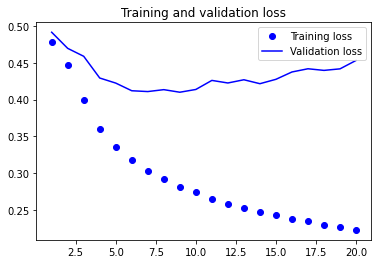

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*순서를 뒤집은 GRU는 굉장히 성능이 낮은 모습. 즉, 시간 순서대로 처리하는 것이 중요한 역할을 한다는 것을 알 수 있음.*

시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 함. 그러나 자연어 처리를 포함한 다른 문제들에서는, 문장을 이해하는데 있어 단어의 중요성은 단어가 문장의 어디에 놓여있는지에 따라 결정되지 않으므로 그렇지 않음.

In [ ]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 9s 26ms/step - loss: 0.4848 - acc: 0.7750 - val_loss: 0.3711 - val_acc: 0.8452
Epoch 2/10
157/157 [==============================] - 4s 23ms/step - loss: 0.3097 - acc: 0.8795 - val_loss: 0.3539 - val_acc: 0.8472
Epoch 3/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2486 - acc: 0.9075 - val_loss: 0.3268 - val_acc: 0.8624
Epoch 4/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2129 - acc: 0.9227 - val_loss: 0.4821 - val_acc: 0.8334
Epoch 5/10
157/157 [==============================] - 4s 22ms/step - loss: 0.1886 - acc: 0.9331 - val_loss: 0.3604 - val_acc: 0.8522
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1762 - acc: 0.9388 - val_loss: 0.4421 - val_acc: 0.8626
Epoch 7/10
157/157 [==============================] - 4s 22ms/step - loss: 0.1501 - acc: 0.9474 - val_loss: 0.3690 - val_acc: 0.8662
Epoch 8/10
157/157 [==============================] - 4s 22ms/step - 

*LSTM IMDB에 적용한 모습. 시간 순서대로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있음.*

<br>

머신러닝에서는 다른 표현이 유용하다면 항상 사용할 가치가 있음. 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아내어 작업의 성능을 올리는 데 도움을 줌. (앙상블)

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을  향상시킴. 입력 시퀀스를 양방향으로 바라보기에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아냄.

<br>

케라스에서는 Bidirectional 층을 사용하여 양방향 RNN을 만듦. 이를 IMDB 감성 분석 문제에 적용.

In [ ]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 11s 50ms/step - loss: 0.5580 - acc: 0.7175 - val_loss: 0.4202 - val_acc: 0.8234
Epoch 2/10
157/157 [==============================] - 9s 58ms/step - loss: 0.3407 - acc: 0.8692 - val_loss: 0.3216 - val_acc: 0.8806
Epoch 3/10
157/157 [==============================] - 9s 56ms/step - loss: 0.2717 - acc: 0.9000 - val_loss: 0.3489 - val_acc: 0.8566
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2315 - acc: 0.9186 - val_loss: 0.3689 - val_acc: 0.8750
Epoch 5/10
157/157 [==============================] - 6s 41ms/step - loss: 0.2038 - acc: 0.9275 - val_loss: 0.3355 - val_acc: 0.8776
Epoch 6/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1833 - acc: 0.9350 - val_loss: 0.3083 - val_acc: 0.8752
Epoch 7/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1697 - acc: 0.9445 - val_loss: 0.3315 - val_acc: 0.8848
Epoch 8/10
157/157 [==============================] - 7s 46ms/step -

*검증 정확도는 88% 정도로 이전의 결과보다 약간 높음.*

동일한 방식을 온도 예측 문제에 적용.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 23s 41ms/step - loss: 0.2928 - val_loss: 0.2724
Epoch 2/40
500/500 [==============================] - 21s 41ms/step - loss: 0.2746 - val_loss: 0.2739
Epoch 3/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2686 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2631 - val_loss: 0.2712
Epoch 5/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2580 - val_loss: 0.2680
Epoch 6/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2527 - val_loss: 0.2696
Epoch 7/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2455 - val_loss: 0.2717
Epoch 8/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2403 - val_loss: 0.2793
Epoch 9/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2374 - val_loss: 0.2824
Epoch 10/40
500/500 [==============================] - 20s 40ms/step - loss: 0.2313 - val_los

*일반 GRU 층과 비슷한 성능. (모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 오는데, 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문)*

# 6.4 컨브넷을 사용한 시퀀스 처리

## 1D 컨브넷 구현

케라스에서 1D 컨브넷은 Conv1D 층을 사용하여 구현. 이는 (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환. 합성곱 윈도우는 시간 축의 1D 윈도우, 즉 입력 텐서의 두 번째 축.

두 개의 층으로 된 1D 컨브넷을 만들어 IMDB 감성 분류에 적용.

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
17464789/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링 층이나 Flatten 층으로 마침. 1D 컨브넷에 크기 7이나 9의 합성곱 윈도우를 사용 가능.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 7s 12ms/step - loss: 0.9535 - acc: 0.5048 - val_loss: 0.6891 - val_acc: 0.5444
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 0.6729 - acc: 0.6358 - val_loss: 0.6696 - val_acc: 0.6502
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.6341 - acc: 0.7493 - val_loss: 0.6342 - val_acc: 0.6612
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5584 - acc: 0.8044 - val_loss: 0.5238 - val_acc: 0.7914
Epoch 5/10
157/157 [==============================] - 2s 11ms/step - loss: 0.4291 - acc: 0.8476 - val_loss: 0.4315 - val_acc: 0.8284
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.3494 - acc: 0.8737 - val_loss: 0.4017 - val_acc: 0.8496
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.3059 - acc: 0.8916 - val_loss: 0.4023 - val_acc: 0.8572
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.273

*검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됨. 단어 수준의 감성 분류 작업에서 순환 네트워크를 대신해 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줌.*

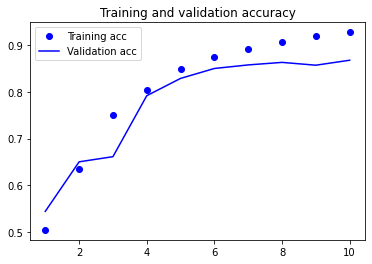

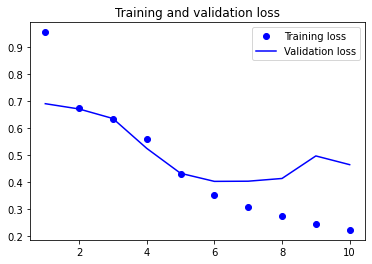

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## CNN과 RNN을 연결하여 긴 시퀀스를 처리

1D 컨브넷이 입력 패치를 독립적으로 처리하기에 RNN과는 달리 타임스텝의 순서에 민감하지 않음.

순서를 감지해야 좋은 예측을 할 수 있는 온도 예측 문제에 1D 컨브넷을 적용하여 확인.

In [ ]:
import os
import numpy as np

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
      
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 17s 31ms/step - loss: 0.4165 - val_loss: 0.4279
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3605 - val_loss: 0.4327
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3371 - val_loss: 0.4527
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3240 - val_loss: 0.4345
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3093 - val_loss: 0.4557
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3006 - val_loss: 0.4432
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2951 - val_loss: 0.4630
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2874 - val_loss: 0.4674
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2811 - val_loss: 0.4585
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2768 - val_los

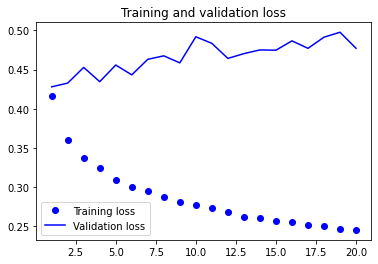

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*검증 MAE는 0.4대에 머물리 있음, 즉 작은 컨브넷을 사용했을때 그렇게 정확하지 않음. 이는 컨브넷이 입력 시계열의 패턴을 보고 시간 축의 위치를 고려하지 않기 때문.*

컨브넷의 속도와 경량을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 이용하는 것.

이를 온도 예측 문제에 적용. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래 전 데이터를 다루거나 시계열 데이터를 더 촘촘하게 바라볼 수 있음.

우선 제너레이터 함수를 다시 사용.

In [14]:
step = 3
lookback = 1440 
delay = 144
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

모델에 두 개의 Conv1D 층 다음에 GRU 층을 놓음.

In [21]:
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_4 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 133s 262ms/step - loss: 0.3258 - val_loss: 0.2977
Epoch 2/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2941 - val_loss: 0.2747
Epoch 3/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2804 - val_loss: 0.2761
Epoch 4/20
500/500 [==============================] - 128s 257ms/step - loss: 0.2683 - val_loss: 0.2768
Epoch 5/20
500/500 [==============================] - 127s 255ms/step - loss: 0.2612 - val_loss: 0.2795
Epoch 6/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2573 - val_loss: 0.2772
Epoch 7/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2497 - val_loss: 0.2849
Epoch 8/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2444 - val_loss: 0.2844
Epoch 9/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2394 - val_loss: 0.2989
Epoch 10/20
500/500 [==============================] - 129s 257ms/step - lo

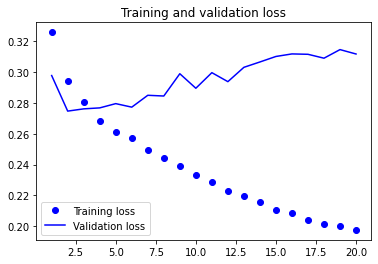

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*검증 손실로 비교 시, 규제가 있는 GRU 모델만큼 좋지는 않음. 하지만 훨씬 빠르기에 데이터를 두 배 더 많이 처리 가능.*

## 정리
- 2D 컨브넷은 2D 공간의 시각 패턴을 잘 처리하는 것과 같이, 1D 컨브넷은 시간에 따른 패턴(시계열 데이터)을 잘 처리. 즉, 특정 자연어 처리 같은 문제에 RNN을 대신할 수 있는 빠른 모델.
- 1D는 2D 컨브넷과 비슷하게 구성. Conv1D 층과 Max-Pooling1D 층을 쌓고 마지막에 전역 풀링 연산이나 Flatten 층을 둠.
- RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 높음. 1D 컨브넷은 비용이 적게 드므로 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하면 적은 비용으로 시퀀스 길이를 줄이고 RNN이 처리할 유용한 표현을 추출해줄 수 있음.